In [2]:
	
# =============================================================================
# Title: Assignment 3.2 - Sentiment Analysis and Preprocessing Text
# Author: Pankaj Yadav
# Date: 21 Dec 2025
# Modified By: Pankaj Yadav
# Description: Sentiment Analysis and Preprocessing Text on Movie Reviews Dataset
# =============================================================================

In [3]:
# Import  libraries
import pandas as pd
import textblob as tb
import torch
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from transformers import pipeline
import unicodedata
import sys


## Part 1: Using the TextBlob Sentiment Analyzer

#### Load data in to dataframe

In [5]:
# Data Source : https://www.kaggle.com/c/word2vec-nlp-tutorial/data

# Import the movie review data as a data frame
df = pd.read_csv('/Users/pyadav/Documents/DSC550-T303/Assignments/labeledTrainData.tsv', sep='\t')
print(df.head(5))

       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


#### Ensure data is loaded properly and do some initial data sanity checks

In [7]:
# Let's do some basic checks on the data and ensure that the data is loaded properly ( check length of dataframe)
print('Length of loaded rows in data frame :',len(df))
print()

# Check for null values
print("Let's check if any rows are missing:\n", df.isnull().sum())  
print()

# Check for duplicate id's
print('There are {} duplicate IDs in the data frame.'.format(df['id'].duplicated().sum()))  
print()

# Check for duplicate reviews
print("Duplicate reviews:", df['review'].duplicated().sum())  
print()

# Print 4 sample duplicate reviews
print(df[df['review'].duplicated(keep=False)].sort_values('review').head(4))

# Check for empty or whitespace-only reviews
print("Empty/whitespace-only reviews:", df['review'].str.strip().eq('').sum())


Length of loaded rows in data frame : 25000

Let's check if any rows are missing:
 id           0
sentiment    0
review       0
dtype: int64

There are 0 duplicate IDs in the data frame.

Duplicate reviews: 96

           id  sentiment                                             review
14734  4102_4          0  'Dead Letter Office' is a low-budget film abou...
5519    985_4          0  'Dead Letter Office' is a low-budget film abou...
7011   6069_8          1  .......Playing Kaddiddlehopper, Col San Fernan...
21163  9319_8          1  .......Playing Kaddiddlehopper, Col San Fernan...
Empty/whitespace-only reviews: 0


In [8]:
# Check how many reviews contain HTML artifacts
print("Reviews containing HTML tags before cleaning:", df['review'].str.contains('<', na=False).sum())
print()

Reviews containing HTML tags before cleaning: 14671



In [9]:
# Remove HTML tags
df['review'] = df['review'].str.replace(r'<.*?>', ' ', regex=True)

The above dataframe contains three columns and 25000 rows. The column names are ID, the sentiment score, and the review.There are no null or missing values in any of the columns. There are 96 duplicate reviews but ID's are unique.

In [11]:
# How many of each positive and negative reviews are there?
print(df['sentiment'].value_counts())


sentiment
1    12500
0    12500
Name: count, dtype: int64


The output above shows that the Sentiment distributiun of 12500 positive and 12500 negative reviews whic means the dataset is perfectly balanced ( 50 - 50 split). 

#### Sentiment analysis using textblob

In [14]:
# Use TextBlob to classify each movie review as positive or negative. 
# Assume that a polarity score greater than or equal to zero is a positive sentiment 
# and less than 0 is a negative sentiment.

# Create a separate column for sentiment predicted by TextBlob and assign binary labels

def classify_sentiment(review):
    analysis = tb.TextBlob(review)
    return 'Positive' if analysis.sentiment.polarity >= 0 else 'Negative'

df['predicted_sentiment'] = df['review'].apply(classify_sentiment)


df['sentiment_label'] = df['predicted_sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

print("Sample reviews with TextBlob predictions:")
print(df[['review', 'sentiment', 'predicted_sentiment']].head(3))

Sample reviews with TextBlob predictions:
                                              review  sentiment  \
0  With all this stuff going down at the moment w...          1   
1  \The Classic War of the Worlds\" by Timothy Hi...          1   
2  The film starts with a manager (Nicholas Bell)...          0   

  predicted_sentiment  
0            Positive  
1            Positive  
2            Negative  


In [15]:
# Check the accuracy of this model. Is this model better than random guessing?
accuracy = accuracy_score(df['sentiment'], df['sentiment_label'])
print('Model Accuracy: {:.2f}%'.format(accuracy * 100))

Model Accuracy: 68.88%


#### Sentiment Analysis using VADER 

In [17]:
# For up to five points extra credit, use another prebuilt text sentiment analyzer, 
# e.g., VADER, and repeat steps (3) and (4). 

sia = SentimentIntensityAnalyzer()
def vader_classify_sentiment(review):
    score = sia.polarity_scores(review)['compound']
    return 'Positive' if score >= 0 else 'Negative'

df['vader_predicted_sentiment'] = df['review'].apply(vader_classify_sentiment)
df['vader_sentiment_label'] = df['vader_predicted_sentiment'].apply(lambda x: 1 if x == 'Positive' else 0  )

print("Sample reviews with Vader predictions:")
print(df[['review', 'sentiment', 'vader_predicted_sentiment']].head(3))

Sample reviews with Vader predictions:
                                              review  sentiment  \
0  With all this stuff going down at the moment w...          1   
1  \The Classic War of the Worlds\" by Timothy Hi...          1   
2  The film starts with a manager (Nicholas Bell)...          0   

  vader_predicted_sentiment  
0                  Negative  
1                  Positive  
2                  Negative  


In [18]:
vader_accuracy = accuracy_score(df['sentiment'], df['vader_sentiment_label'])
print('VADER Model Accuracy: {:.2f}%'.format(vader_accuracy * 100))

VADER Model Accuracy: 69.55%


As you see, there is not a significant difference between VADER and TextBlob models when applied to the same data. VADER demonstrates slightly better performance in predicting sentiments, with an accuracy advantage of approximately 0.67% compared to TextBlob. Both models perform better than random guessing (50%), with TextBlob achieving 68.88% accuracy and VADER achieving 69.55% accuracy.

#### Sentiment analysis using transformers model

In [34]:
# Using Hugging Face transformers pipeline for sentiment analysis

sentiment_pipeline = pipeline('sentiment-analysis')
def tf_classify_sentiment(review):

    # Truncate review to first 512 characters which is model's max characterlimit as there are some 
    # reviews > 800 characters throwing errors

    result = sentiment_pipeline(review[:512])[0]  
    return result['label']
df['tf_predicted_sentiment'] = df['review'].apply(tf_classify_sentiment)
df['tf_sentiment_label'] = df['tf_predicted_sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0  )

print("Sample reviews with transformers predictions:")
print(df[['review', 'sentiment', 'tf_predicted_sentiment']].head(3))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Sample reviews with transformers predictions:
                                              review  sentiment  \
0  With all this stuff going down at the moment w...          1   
1  \The Classic War of the Worlds\" by Timothy Hi...          1   
2  The film starts with a manager (Nicholas Bell)...          0   

  tf_predicted_sentiment  
0               POSITIVE  
1               POSITIVE  
2               NEGATIVE  


In [36]:

tf_accuracy = (df['sentiment'] == df['tf_sentiment_label']).mean()
print('Transformers Model Accuracy: {:.2f}%'.format(tf_accuracy * 100))

Transformers Model Accuracy: 82.71%




The transformer sentiment analysis model significantly outperforms both the TextBlob and VADER models:

- Hugging Face advantage over TextBlob : +12.17 percentage points
- Hugging Face advantage over VADER : +11.50 percentage points

The transformer model demonstrates superior performance due to its deep learning architecture trained on large corpora of text data. While TextBlob and VADER use rule-based and statistical approaches with comparable results (~69%), the transformer model better understand nuanced sentiment expressions in movie reviews. This makes it particularly effective for capturing complex sentiment patterns.

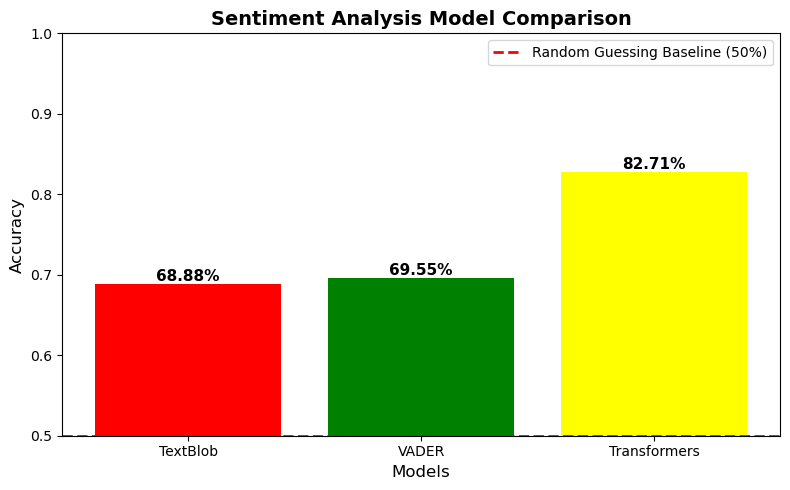

In [38]:
# Let's Visualize the comparison of accuracies of all three models using a bar chart.


models = ['TextBlob', 'VADER', 'Transformers']
accuracies = [
    (df['sentiment'] == df['sentiment_label']).mean(),
    (df['sentiment'] == df['vader_sentiment_label']).mean(),
    (df['sentiment'] == df['tf_sentiment_label']).mean()
]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['red', 'green', 'yellow'])
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Sentiment Analysis Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0.5, 1.0])
plt.axhline(y=0.5, color='red', linestyle='--', label='Random Guessing Baseline (50%)', linewidth=2)

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

## Part 2: Prepping Text for a Custom Model

In [40]:
# Convert all text to lowercase letters

df['review'] = df['review'].str.lower()

print(df.head(5))

       id  sentiment                                             review  \
0  5814_8          1  with all this stuff going down at the moment w...   
1  2381_9          1  \the classic war of the worlds\" by timothy hi...   
2  7759_3          0  the film starts with a manager (nicholas bell)...   
3  3630_4          0  it must be assumed that those who praised this...   
4  9495_8          1  superbly trashy and wondrously unpretentious 8...   

  predicted_sentiment  sentiment_label vader_predicted_sentiment  \
0            Positive                1                  Negative   
1            Positive                1                  Positive   
2            Negative                0                  Negative   
3            Positive                1                  Negative   
4            Negative                0                  Positive   

   vader_sentiment_label tf_predicted_sentiment  tf_sentiment_label  
0                      0               POSITIVE                   1  


In [41]:
# Remove punctuation and special characters using unicode data library.

punctuation = dict.fromkeys(
  (i for i in range(sys.maxunicode)
  if unicodedata.category(chr(i)).startswith('P')
  ),
  None
)

#  Remove any punctuation characters
df['review'] = df['review'].apply(lambda x: x.translate(punctuation))

# Strip whitespaces and reduce multiple spaces to a single space
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True)

# Remove numbers
df['review'] = df['review'].str.replace(r'\d+', '', regex=True)

# Check a few cleaned samples to ensure they look
print(df['review'].head(5))

0    with all this stuff going down at the moment w...
1    the classic war of the worlds by timothy hines...
2    the film starts with a manager nicholas bell g...
3    it must be assumed that those who praised this...
4    superbly trashy and wondrously unpretentious s...
Name: review, dtype: object


The preprocessing pipeline converting to lowercase, removing punctuation, eliminating HTML Tags dramatically reduces noise and improves the quality of data.


In [43]:
# tokenize the reviews 

df['tokenized_review'] = df['review'].apply(word_tokenize)

print('tokenized reviews:\n', df['tokenized_review'].head(5))

tokenized reviews:
 0    [with, all, this, stuff, going, down, at, the,...
1    [the, classic, war, of, the, worlds, by, timot...
2    [the, film, starts, with, a, manager, nicholas...
3    [it, must, be, assumed, that, those, who, prai...
4    [superbly, trashy, and, wondrously, unpretenti...
Name: tokenized_review, dtype: object


In [44]:
# Stop words removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

df['tokenized_review'] = df['tokenized_review'].apply(remove_stopwords)

print('Reviews after stop words removal:\n', df['tokenized_review'].head(5))


Reviews after stop words removal:
 0    [stuff, going, moment, mj, ive, started, liste...
1    [classic, war, worlds, timothy, hines, enterta...
2    [film, starts, manager, nicholas, bell, giving...
3    [must, assumed, praised, film, greatest, filme...
4    [superbly, trashy, wondrously, unpretentious, ...
Name: tokenized_review, dtype: object



Stop Word Removal eliminates common words like 'the', 'is', 'and', and 'a' that appear in virtually every review regardless of sentiment. These words carry little discriminative power for sentiment classification. By removing them, we reduce the vocabulary size  and training time, and allow to focus on import words like 'excellent', 'terrible', 'disappointing', and 'beautiful' that have more sentimental values.

In [46]:
# Apply NLTK’s PorterStemmer.

ps = PorterStemmer()
df['stemmed_review'] = df['tokenized_review'].apply(lambda tokens: [ps.stem(word) for word in tokens])

print('stemmed :\n', df['stemmed_review'].head(5))

stemmed :
 0    [stuff, go, moment, mj, ive, start, listen, mu...
1    [classic, war, world, timothi, hine, entertain...
2    [film, start, manag, nichola, bell, give, welc...
3    [must, assum, prais, film, greatest, film, ope...
4    [superbl, trashi, wondrous, unpretenti, exploi...
Name: stemmed_review, dtype: object



Stemming reduces words to their root form using the Porter Stemmer algorithm. This groups related words that convey similar meanings, e.g. 'running', 'runs' and 'run' all reduce to "run"; 'beautifully', 'beautiful' and 'beauty' all reduce to a common stem. 

Together stop word removal and stemming steps reduce the raw English vocabulary of millions of words to a manageable set of meaningful features. This enables models to train faster, use less memory, and generalize better to new reviews.

In [48]:
# Create a bag-of-words matrix from your stemmed text (output from (4)), 
# where each row is a word-count vector for a single movie review 
# (see sections 5.3 & 6.8 in the Machine Learning with Python Cookbook). 
# Display the dimensions of your bag-of-words matrix. 
# The number of rows in this matrix should be the same as the number of rows in your original data frame.

# Join the stemmed tokens back into strings for CountVectorizer

df['stemmed_review_str'] = df['stemmed_review'].apply(lambda tokens: ' '.join(tokens))
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(df['stemmed_review_str'])
print(bow_matrix.shape)

(25000, 80250)


In [49]:
# Print first 2 rows of BOW sparse matrix and print non-zero entries with word counts
 
for i in range(2):
    row = bow_matrix[i]
    non_zero = row.nonzero()[1]
    print(f"\nReview {i}: {len(non_zero)} unique words")
    # Show first 10 non-zero entries
    for idx in non_zero[:10]:
        word = count_vectorizer.get_feature_names_out()[idx]
        count = row[0, idx]
        print(f"  {word}: {count}")


Review 0: 157 unique words
  stuff: 1
  go: 3
  moment: 1
  mj: 11
  ive: 2
  start: 2
  listen: 1
  music: 2
  watch: 3
  odd: 1

Review 1: 61 unique words
  watch: 1
  film: 2
  movi: 2
  made: 1
  peopl: 1
  thing: 1
  well: 2
  differ: 1
  fact: 1
  classic: 3


In [50]:
# Create a term frequency-inverse document frequency (tf-idf) matrix from your stemmed text, for your movie 
# reviews (see section 6.9 in the Machine Learning with Python Cookbook). Display the dimensions of your 
# tf-idf matrix. These dimensions should be the same as your bag-of-words matrix.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['stemmed_review_str'])
print(tfidf_matrix.shape)   

(25000, 80250)


In [51]:
# Print first 2 rows of TF-IDF matrix and print non-zero entries with words importance weightage
for i in range(2):
    row = tfidf_matrix[i]
    non_zero = row.nonzero()[1]
    print(f"\nReview {i}: {len(non_zero)} unique words")
    # Show first 10 non-zero entries with highest TF-IDF scores
    scores = [(tfidf_vectorizer.get_feature_names_out()[idx], row[0, idx]) 
              for idx in non_zero]
    scores.sort(key=lambda x: x[1], reverse=True)
    for word, score in scores[:10]:
        print(f"  {word}: {score:.4f}")


Review 0: 157 unique words
  mj: 0.7802
  moonwalk: 0.1335
  pesci: 0.1327
  drug: 0.1200
  messag: 0.1106
  hate: 0.1027
  sequenc: 0.0985
  peopl: 0.0981
  guilti: 0.0975
  jackson: 0.0974

Review 1: 61 unique words
  hine: 0.4616
  critic: 0.3368
  classic: 0.2112
  baseslik: 0.2020
  faith: 0.1971
  entertain: 0.1945
  effort: 0.1658
  mr: 0.1610
  obvious: 0.1607
  hg: 0.1509


Both the Bag-of-Words (BOW) and TF-IDF matrices are sparse, meaning they contain predominantly zero values. This sparsity occurs because each individual review contains only a small fraction of the total vocabulary , most words do not appear in most reviews. For example, with 25,000 reviews and tens of thousands of unique words, a typical review may contain only 100-200 unique words, resulting in a matrix that is 99%+ zeros.